Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# displaying sample images

In [1]:
import retinoto_py as fovea
N_show = 6
args = fovea.Params(batch_size=N_show, do_mask=False, n_val_stop=N_show)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=1998, batch_size=6, num_workers=4, in_memory=True, model_name='resnet101', do_scratch=False, num_epochs=10, n_train_stop=32768, n_val_stop=6, lr=1e-06, delta1=0.02, delta2=0.0, weight_decay=0.01, label_smoothing=0.0, shuffle=True, verbose=True)

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
# VAL_DATA_DIR = args.DATAROOT / 'Imagenet_bbox' / 'val'
val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)

Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break

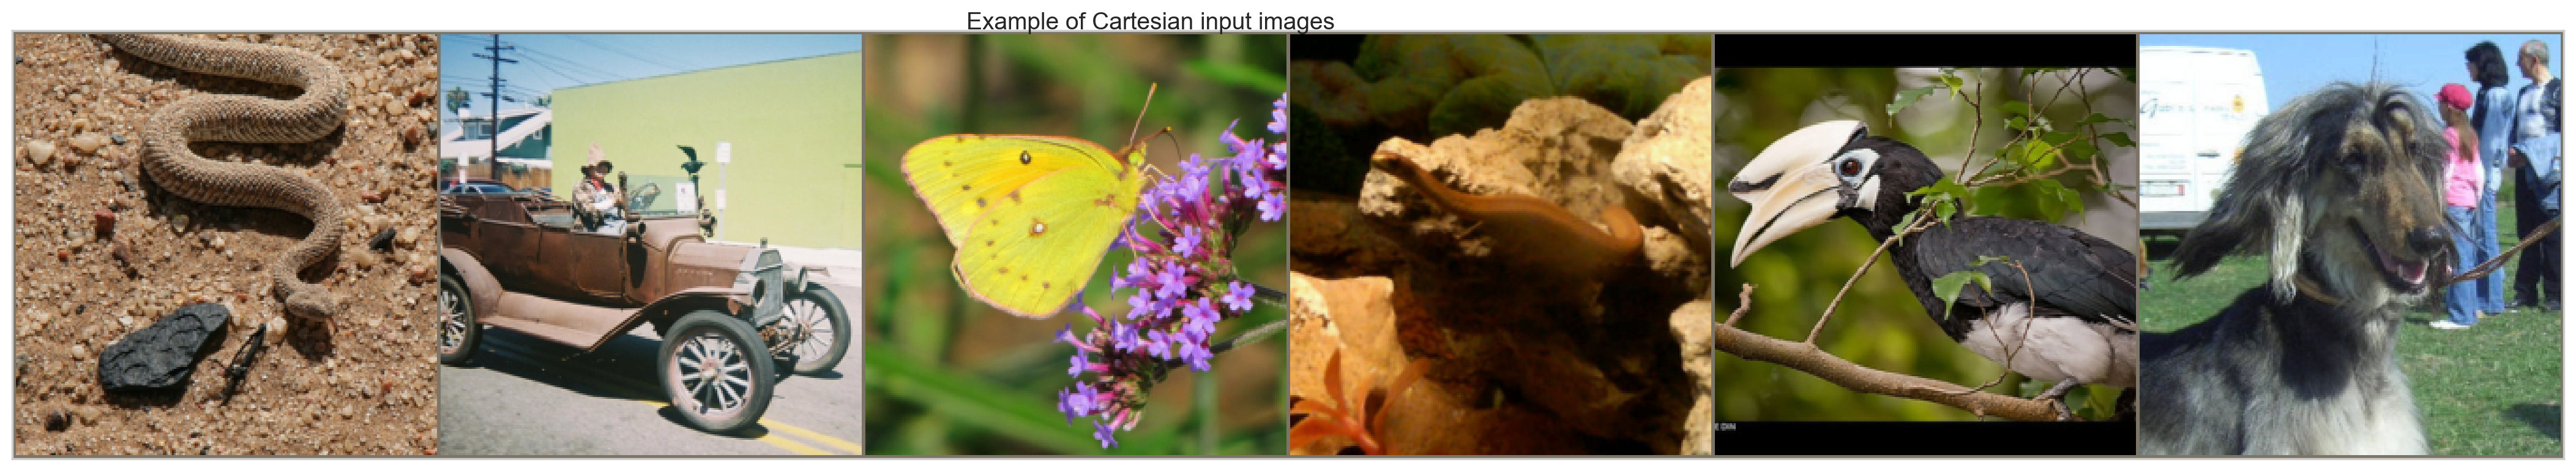

In [4]:
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask

Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

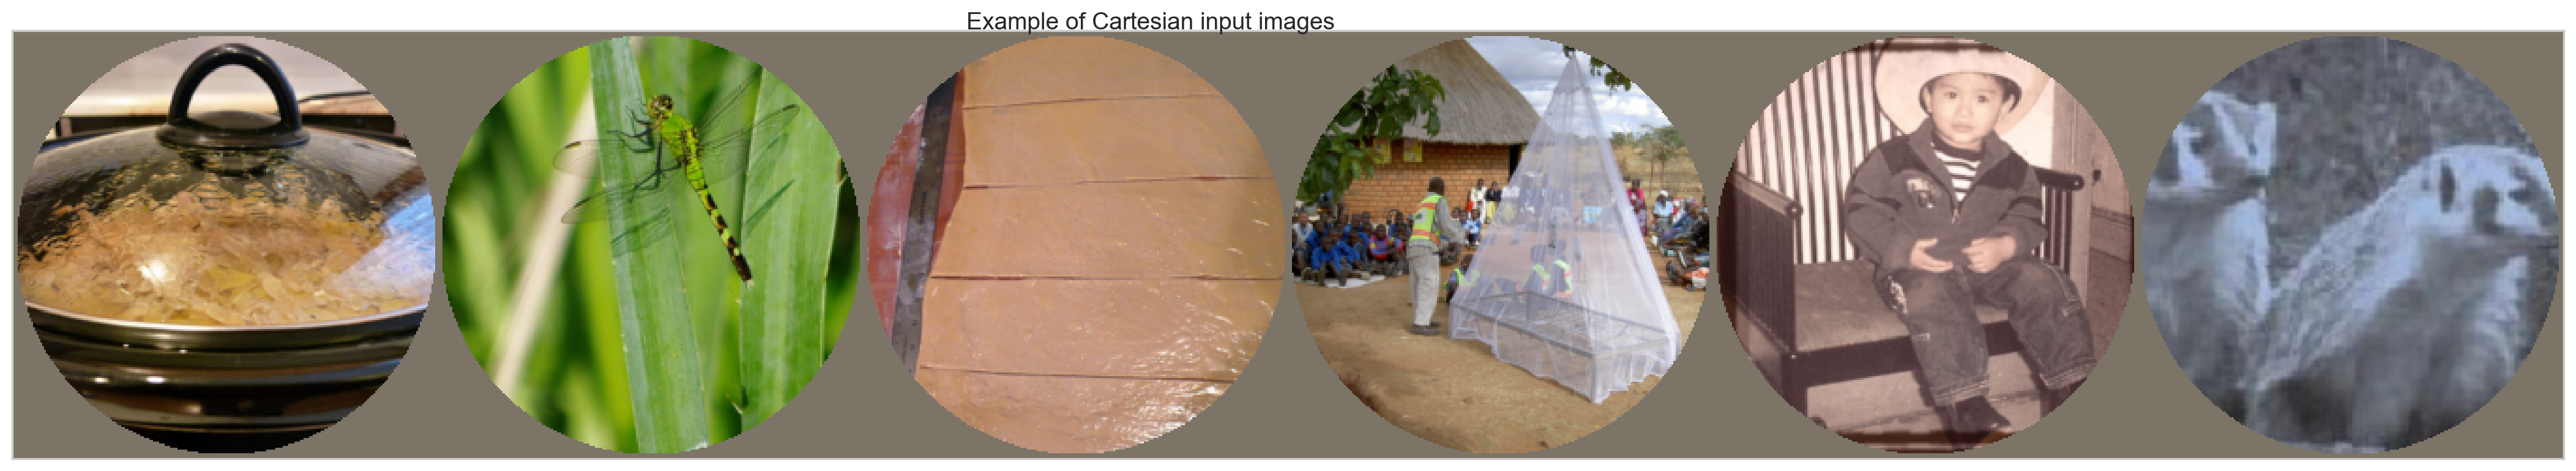

In [5]:
args = fovea.Params(batch_size=N_show, do_mask=True, n_val_stop=N_show)
val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask and a rotation

Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

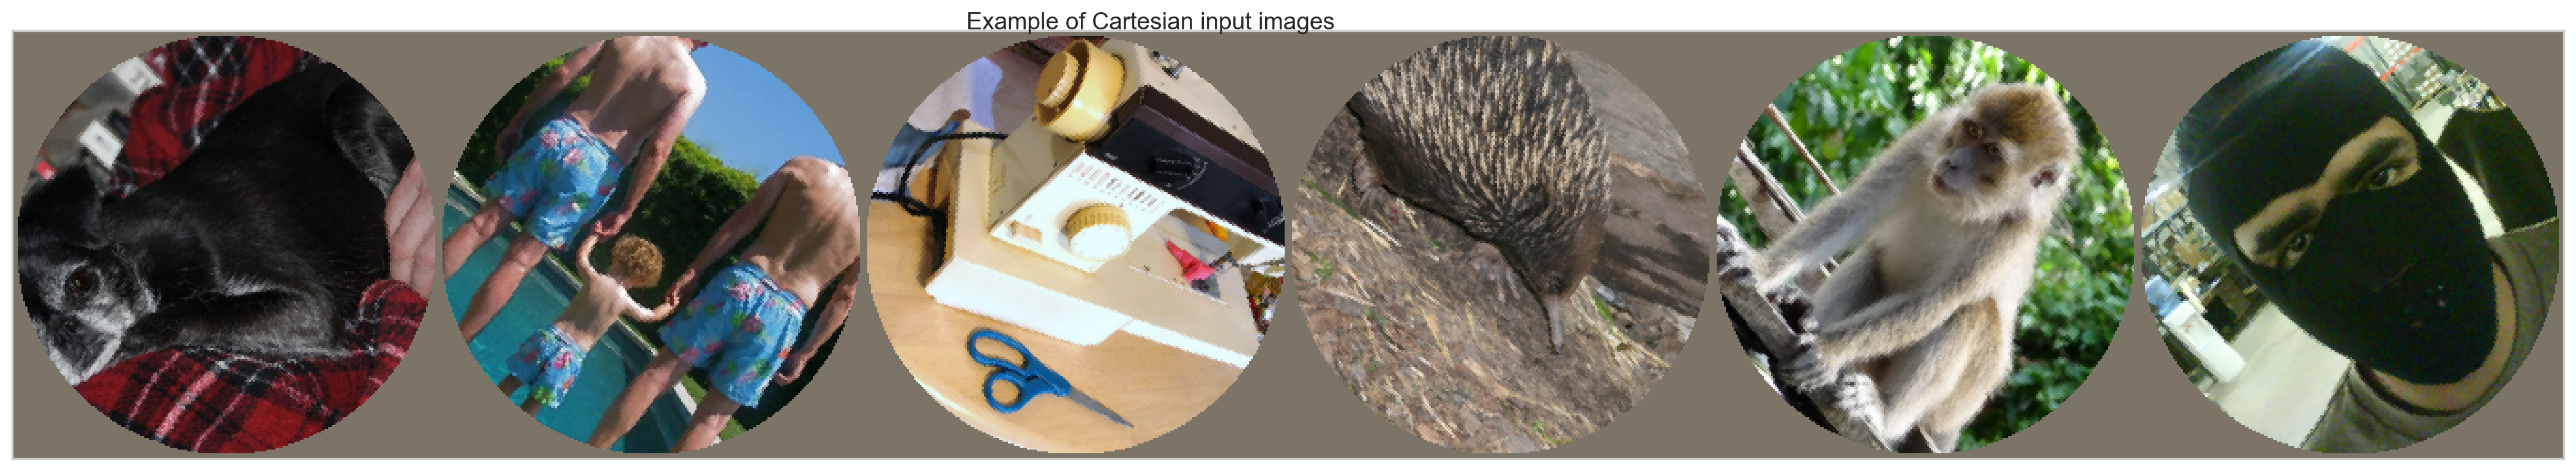

In [6]:
args = fovea.Params(batch_size=N_show, do_mask=True, n_val_stop=N_show)
val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, angle_min=40, angle_max=50, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# testing one image at different rotations

In [7]:
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=71, n_val_stop=N_show)
val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=N_show)
val_loader = fovea.get_loader(args, val_dataset)
model = fovea.load_model(args)
model.eval()
for images, true_labels in val_loader:
    images = images.to(args.device)
    true_labels = true_labels.to(args.device)
    break
images.shape, true_labels


Putting images in memory:   0%|          | 0/6 [00:00<?, ?it/s]

(torch.Size([1, 3, 224, 224]), tensor([679], device='mps:0'))

In [8]:
all_angles = fovea.np.linspace(0, 360, 22) 


In [9]:
all_image_tensors = []
all_label_tensors = []

mask = fovea.make_mask(args.image_size).to(args.device)
for angle in all_angles:
    image_rot = fovea.TF.rotate(images, angle) * mask
    
    # Append the batch of rotated images and their corresponding labels
    all_image_tensors.append(image_rot)
    all_label_tensors.append(true_labels) # Append the full label tensor

# --- AFTER THE LOOP: Concatenate everything at once ---
# This is the efficient way!
all_images = fovea.torch.cat(all_image_tensors, dim=0)
all_labels = fovea.torch.cat(all_label_tensors, dim=0)

all_images.shape, all_labels.shape

(torch.Size([22, 3, 224, 224]), torch.Size([22]))

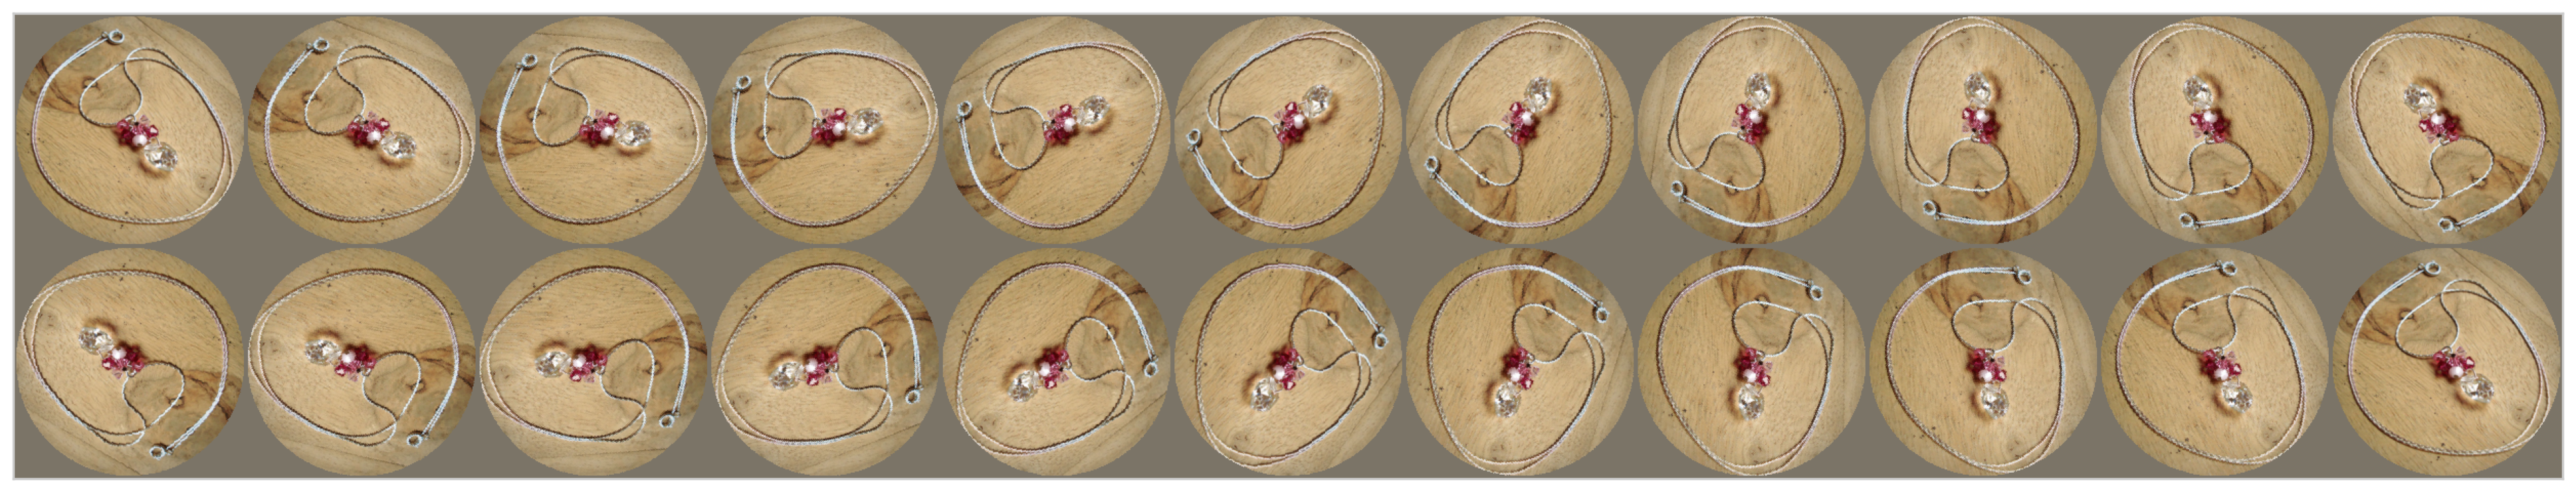

In [10]:
fig, ax = fovea.imshow(all_images.cpu(), fig_height=5)

In [11]:
criterion = fovea.nn.CrossEntropyLoss(reduction='none')
with fovea.torch.no_grad():
    outputs = model(all_images)
    loss = criterion(outputs, all_labels).cpu().numpy()
    logits = outputs.cpu().numpy()

    _, predicted_labels = fovea.torch.max(outputs, dim=1)
    correct_predictions_in_batch = (predicted_labels == all_labels)
predicted_labels, all_labels

(tensor([679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679], device='mps:0'),
 tensor([679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679, 679], device='mps:0'))

In [12]:
correct_predictions_in_batch, loss

(tensor([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True],
        device='mps:0'),
 array([0.44155532, 0.3075151 , 0.27828866, 0.29859754, 0.42667744,
        0.3745168 , 0.18371755, 0.31826904, 0.6596666 , 0.48055142,
        0.44844016, 0.34567788, 0.16302082, 0.30935726, 0.4132168 ,
        0.51965535, 0.5901965 , 0.23754296, 0.30102122, 0.35985374,
        0.46445286, 0.44155532], dtype=float32))

In [13]:
worst_angle = loss.argmax()
worst_angle, predicted_labels[worst_angle]

(np.int64(8), tensor(679, device='mps:0'))

In [14]:
idx_to_label = fovea.get_idx_to_label(args)
idx_to_label[predicted_labels[worst_angle]]

Loading labels from local cache cached_data/imagenet_class_index.json...


'necklace'

In [15]:
all_images[[0, worst_angle], ...].shape

torch.Size([2, 3, 224, 224])

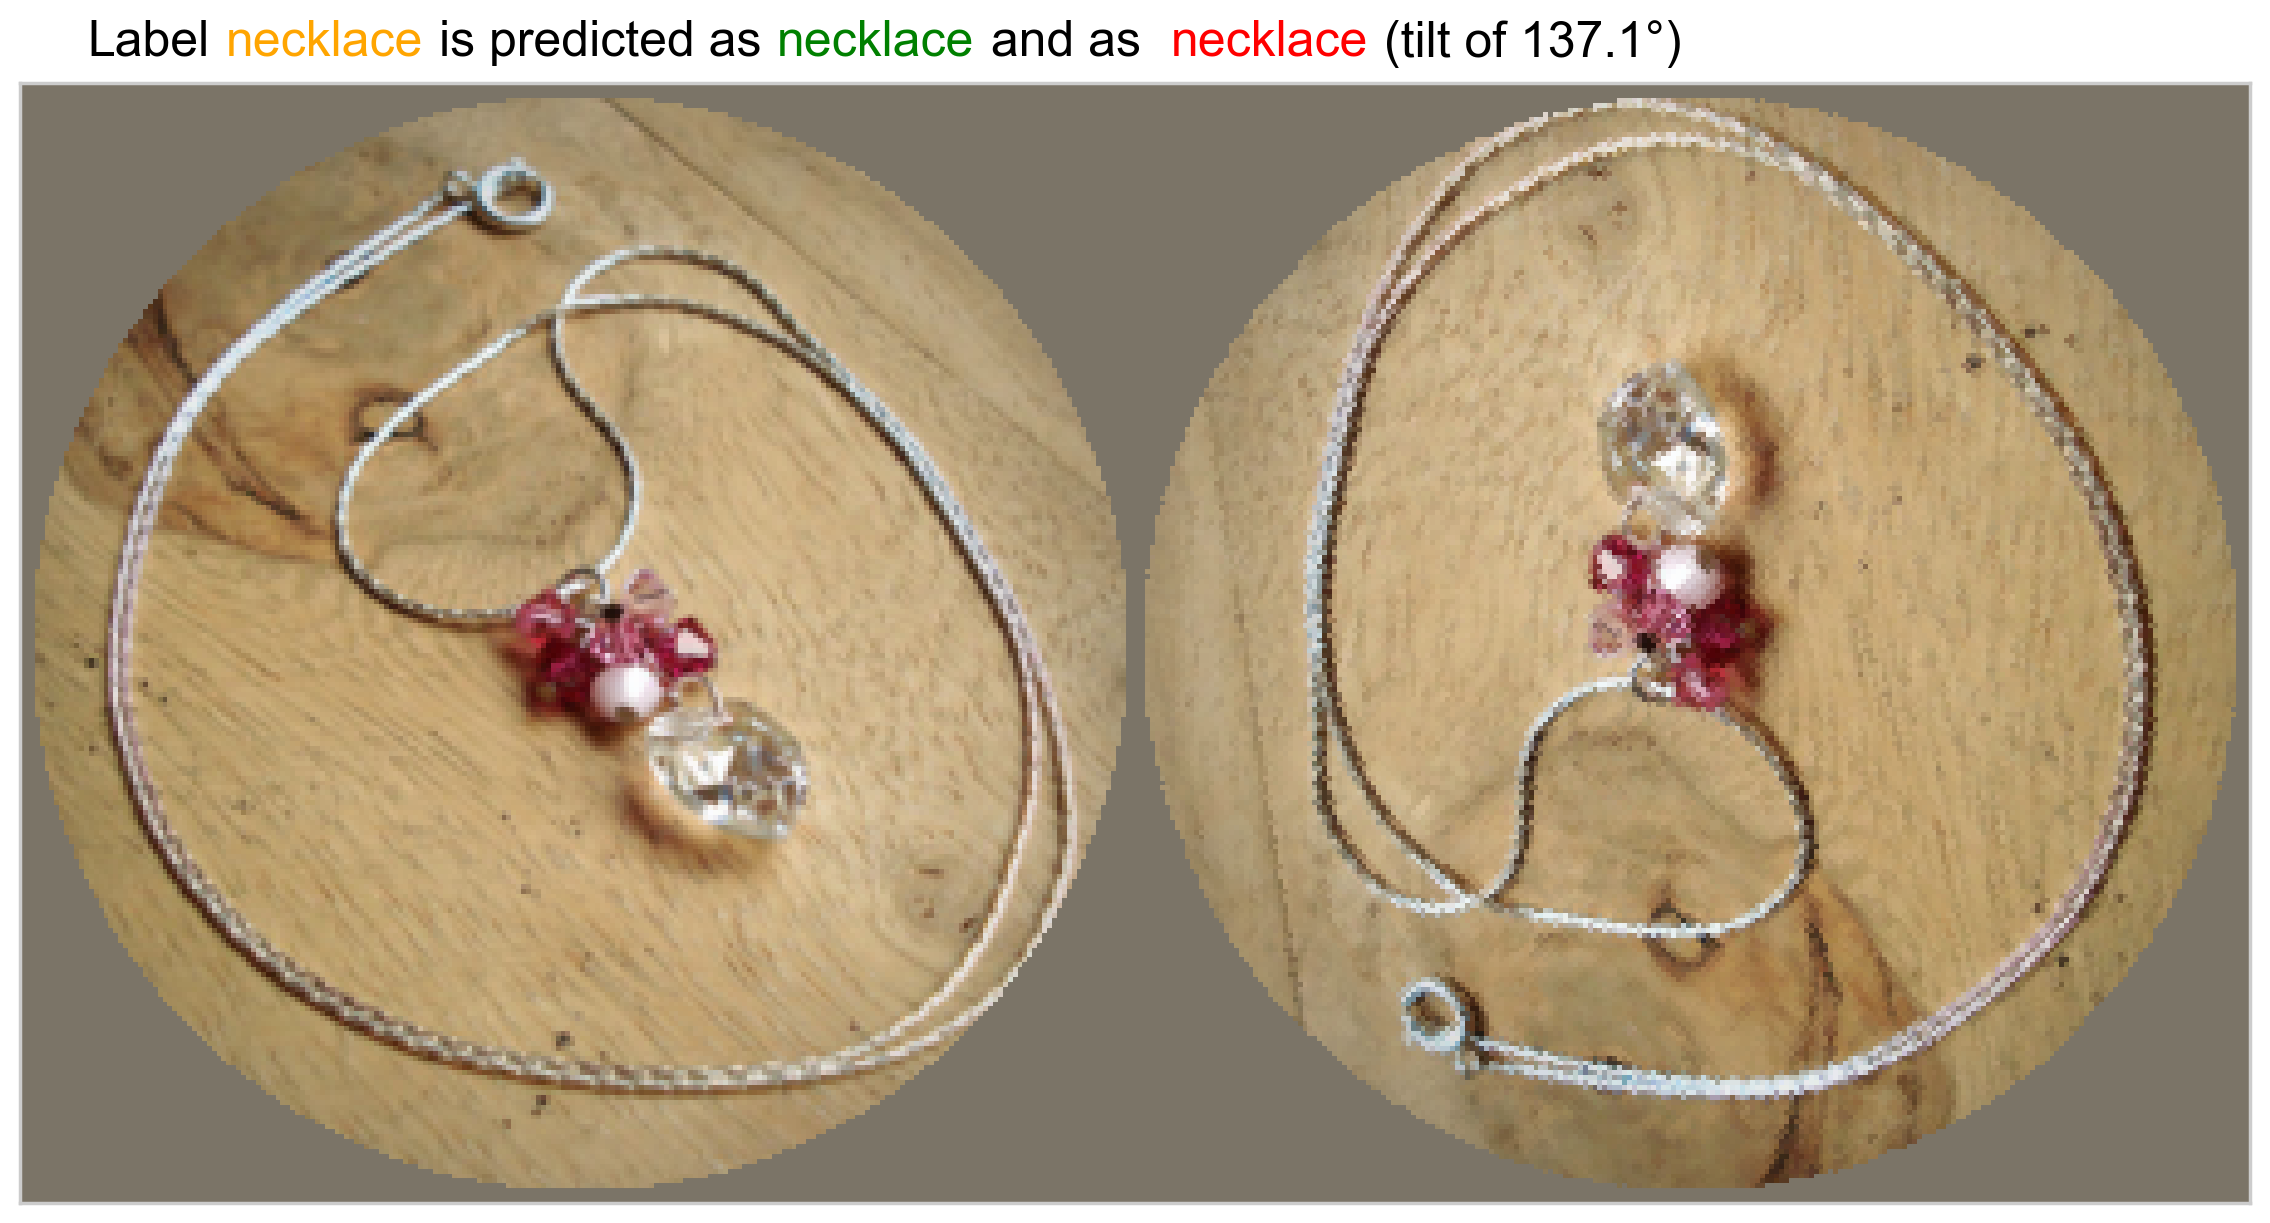

In [16]:
fig_height = 8

def make_title(fig, ax, A, B, C):
    # We position text relative to the FIGURE (0-1), not the axes.
    # This avoids transform complexities.
    transform = fig.transFigure
    
    text_segments = [
        (f"Label", 'black'),
        (f"{A}", 'orange'),
        (f"is predicted as", 'black'),
        (f"{B}", 'green'),
        (f"and as ", 'black'),
        (f"{C}", 'red'),
        (f"(tilt of {all_angles[worst_angle]:.1f}°)", 'black',),
    ]
    
    # Position the title block relative to the figure's width
    x_pos = 0.21 # Start 5% from the left edge of the figure
    y_pos = 0.99  # Start 97% from the bottom of the figure
    font_size = ax.title.get_fontsize() #or plt.rcParams['font.size'] # Get title font size

    for segment, color in text_segments:
        text_obj = fig.text(x_pos, y_pos, segment, color=color, transform=transform, 
                            fontsize=font_size, va='top', ha='left')
        
        # Draw the canvas to ensure the bbox is accurate
        fig.canvas.draw()
        bbox = text_obj.get_window_extent()
        
        # The spacing is now just the width of the text in figure coordinates
        x_pos = (bbox.x1 - fig.bbox.x0) / fig.bbox.width + 0.005 # Add a small space

    return fig, ax


fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=None, fig_height=fig_height)
fig, ax = make_title(fig, ax, idx_to_label[all_labels[0]], idx_to_label[predicted_labels[0]], idx_to_label[predicted_labels[worst_angle]])
# fig.tight_layout()

In [17]:
def one_rotation_attack(image, true_label, all_angles=fovea.np.linspace(0, 360, 22), fig_height = 6):

    all_image_tensors = []
    all_label_tensors = []
    for angle in all_angles:
        image_rot = fovea.TF.rotate(image, angle) * mask
        all_image_tensors.append(image_rot)
        all_label_tensors.append(true_label) # Append the full label tensor
    all_images = fovea.torch.cat(all_image_tensors, dim=0)
    all_labels = fovea.torch.cat(all_label_tensors, dim=0)

    with fovea.torch.no_grad():
        outputs = model(all_images)
        loss = criterion(outputs, all_labels).cpu().numpy()
        _, predicted_labels = fovea.torch.max(outputs, dim=1)

    worst_angle = loss.argmax()
    
    fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=None, fig_height=fig_height)
    fig, ax = make_title(fig, ax, idx_to_label[all_labels[0]], idx_to_label[predicted_labels[0]], idx_to_label[predicted_labels[worst_angle]])
    # fig.tight_layout()

    return fig, ax



In [18]:
figures_folder = args.figures_folder / '16_attack'
figures_folder.mkdir(exist_ok=True)
n_images = 101
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True)
val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, in_memory=True, n_stop=n_images)
val_loader = fovea.get_loader(args, val_dataset)
model = fovea.load_model(args)
model.eval()

for i_image, (image, true_label) in enumerate(val_loader):
    image = image.to(args.device)
    true_label = true_label.to(args.device)
    fig, ax = one_rotation_attack(image, true_label)
    name =  f'16_attack-{i_image}'
    fovea.savefig(fig, name=name, figures_folder=args.figures_folder / '16_attack', exts=['png'])
    fovea.plt.close() # will close the plot
    print(f'Saved {name}', end='\t')

Putting images in memory:   0%|          | 0/101 [00:00<?, ?it/s]

Saved 16_attack-0	Saved 16_attack-1	Saved 16_attack-2	Saved 16_attack-3	Saved 16_attack-4	Saved 16_attack-5	Saved 16_attack-6	Saved 16_attack-7	Saved 16_attack-8	Saved 16_attack-9	Saved 16_attack-10	Saved 16_attack-11	Saved 16_attack-12	Saved 16_attack-13	Saved 16_attack-14	Saved 16_attack-15	Saved 16_attack-16	Saved 16_attack-17	Saved 16_attack-18	Saved 16_attack-19	Saved 16_attack-20	Saved 16_attack-21	Saved 16_attack-22	Saved 16_attack-23	Saved 16_attack-24	Saved 16_attack-25	Saved 16_attack-26	Saved 16_attack-27	Saved 16_attack-28	Saved 16_attack-29	Saved 16_attack-30	Saved 16_attack-31	Saved 16_attack-32	Saved 16_attack-33	Saved 16_attack-34	Saved 16_attack-35	Saved 16_attack-36	Saved 16_attack-37	Saved 16_attack-38	Saved 16_attack-39	Saved 16_attack-40	Saved 16_attack-41	Saved 16_attack-42	Saved 16_attack-43	Saved 16_attack-44	Saved 16_attack-45	Saved 16_attack-46	Saved 16_attack-47	Saved 16_attack-48	Saved 16_attack-49	Saved 16_attack-50	Saved 16_attack-51	Saved 16_attack-52	Sav

# testing each network for different rotations

In [19]:
all_angles = fovea.np.linspace(0, 180, 25)
all_angles

array([  0. ,   7.5,  15. ,  22.5,  30. ,  37.5,  45. ,  52.5,  60. ,
        67.5,  75. ,  82.5,  90. ,  97.5, 105. , 112.5, 120. , 127.5,
       135. , 142.5, 150. , 157.5, 165. , 172.5, 180. ])

In [20]:
delta_angle = all_angles[1] - all_angles[0]
all_angles_min = all_angles - delta_angle / 2
all_angles_min, all_angles_min + delta_angle, delta_angle

(array([ -3.75,   3.75,  11.25,  18.75,  26.25,  33.75,  41.25,  48.75,
         56.25,  63.75,  71.25,  78.75,  86.25,  93.75, 101.25, 108.75,
        116.25, 123.75, 131.25, 138.75, 146.25, 153.75, 161.25, 168.75,
        176.25]),
 array([  3.75,  11.25,  18.75,  26.25,  33.75,  41.25,  48.75,  56.25,
         63.75,  71.25,  78.75,  86.25,  93.75, 101.25, 108.75, 116.25,
        123.75, 131.25, 138.75, 146.25, 153.75, 161.25, 168.75, 176.25,
        183.75]),
 np.float64(7.5))

In [21]:
for model_name in  fovea.all_model_names:
    print(f'{model_name=}')

model_name='resnet18'
model_name='resnet50'
model_name='resnet101'


In [22]:
for angles_min, angles_max in zip(all_angles_min, all_angles_min + delta_angle):
    print(f'{fovea.np.mod(angles_min,360)=:.3f}\t{fovea.np.mod(angles_max, 360)=:.3f}')

fovea.np.mod(angles_min,360)=356.250	fovea.np.mod(angles_max, 360)=3.750
fovea.np.mod(angles_min,360)=3.750	fovea.np.mod(angles_max, 360)=11.250
fovea.np.mod(angles_min,360)=11.250	fovea.np.mod(angles_max, 360)=18.750
fovea.np.mod(angles_min,360)=18.750	fovea.np.mod(angles_max, 360)=26.250
fovea.np.mod(angles_min,360)=26.250	fovea.np.mod(angles_max, 360)=33.750
fovea.np.mod(angles_min,360)=33.750	fovea.np.mod(angles_max, 360)=41.250
fovea.np.mod(angles_min,360)=41.250	fovea.np.mod(angles_max, 360)=48.750
fovea.np.mod(angles_min,360)=48.750	fovea.np.mod(angles_max, 360)=56.250
fovea.np.mod(angles_min,360)=56.250	fovea.np.mod(angles_max, 360)=63.750
fovea.np.mod(angles_min,360)=63.750	fovea.np.mod(angles_max, 360)=71.250
fovea.np.mod(angles_min,360)=71.250	fovea.np.mod(angles_max, 360)=78.750
fovea.np.mod(angles_min,360)=78.750	fovea.np.mod(angles_max, 360)=86.250
fovea.np.mod(angles_min,360)=86.250	fovea.np.mod(angles_max, 360)=93.750
fovea.np.mod(angles_min,360)=93.750	fovea.np.mod(ang

In [ ]:
for dataset in fovea.all_datasets:
    for model_name in fovea.all_model_names:
        npz_filename = args.data_cache / f'16_all_name={model_name}_dataset={dataset}.npz'
        print(f'Rotation attack for {model_name=} and {dataset=} \t {npz_filename=}')

        # %rm {npz_filename}  # FORCING RECOMPUTE

        if npz_filename.exists():
            with fovea.np.load(npz_filename) as data:
                # --- 3. Access the arrays inside the 'with' block ---
                # It's good practice to convert to tensors (or whatever final format you need)
                # right away, so you don't need to keep the file open.
                attack_angle = data['attack_angle']
                attack_success = data['attack_success']
                all_results = data['results']
        else:
            VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
            args = fovea.Params(shuffle=False, do_mask=True, model_name=model_name, batch_size=500)
            model = fovea.load_model(args)
            model.eval()

            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 
            criterion = fovea.nn.CrossEntropyLoss(reduction='none')
            dataset_len = len(val_loader.dataset)
            all_results = fovea.np.empty((len(all_angles), dataset_len)) 
            all_logits = fovea.np.empty((len(all_angles), dataset_len, model.fc.out_features)) 
            all_losses = fovea.np.empty((len(all_angles), dataset_len)) 
            all_labels = []
            outer_progress = fovea.tqdm(
                                    enumerate(zip(all_angles_min, all_angles_min + delta_angle)),
                                    total=len(all_angles_min),
                                    desc="Validating Angles", 
                                    leave=False
                                )
            for i_angle, (angle_min, angle_max) in outer_progress:
                val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, 
                                                                    angle_min=angle_min, angle_max=angle_max, in_memory=False)
                val_loader = fovea.get_loader(args, val_dataset)

                correct_predictions = 0
                total_predictions = 0

                image_count = 0
                for images, true_labels in fovea.tqdm(val_loader, desc=f"Angle [{.5*(angle_min+angle_max):.1f}°]", position=1, leave=False):
                    images = images.to(args.device)
                    true_labels = true_labels.to(args.device)

                    # Get predictions (no need for gradients)
                    with fovea.torch.no_grad():
                        if i_angle==0: all_labels.extend([l.item() for l in true_labels])
                        outputs = model(images)
                        all_logits[i_angle, image_count:(image_count + images.size(0)), :] = outputs.cpu().numpy()
                        _, predicted_labels = fovea.torch.max(outputs, dim=1)
                        correct_predictions_in_batch = (predicted_labels == true_labels)
                        all_results[i_angle, image_count:image_count + images.size(0)] = correct_predictions_in_batch.cpu().numpy()
                        loss = criterion(outputs, true_labels)
                        all_losses[i_angle, image_count:(image_count + images.size(0))] = loss.cpu().numpy()
                    image_count += images.size(0)
                outer_progress.set_postfix(last_acc=f"{all_results[i_angle, :].mean():.4f}")

            attack_angle = all_losses.argmax(axis=0)
            attack_idx = all_logits[attack_angle, fovea.np.arange(dataset_len), :].argmax(axis=1)
            attack_success = (attack_idx == all_labels)

            fovea.np.savez(npz_filename, 
                    attack_angle=attack_angle,
                    attack_success=attack_success,
                    results=all_results)



Rotation attack for model_name='resnet18' and dataset='full' 	 npz_filename=PosixPath('cached_data/16_all_name=resnet18_dataset=full.npz')
Rotation attack for model_name='resnet50' and dataset='full' 	 npz_filename=PosixPath('cached_data/16_all_name=resnet50_dataset=full.npz')
Rotation attack for model_name='resnet101' and dataset='full' 	 npz_filename=PosixPath('cached_data/16_all_name=resnet101_dataset=full.npz')
Rotation attack for model_name='resnet18' and dataset='bbox' 	 npz_filename=PosixPath('cached_data/16_all_name=resnet18_dataset=bbox.npz')


Validating Angles:   0%|          | 0/25 [00:00<?, ?it/s]

Angle [0.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [7.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [15.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [22.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [30.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [37.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [45.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [52.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [60.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [67.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [75.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [82.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [90.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [97.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [105.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [112.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [120.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [127.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [135.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [142.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [150.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [157.5°]:   0%|          | 0/160 [00:00<?, ?it/s]

Angle [165.0°]:   0%|          | 0/160 [00:00<?, ?it/s]

# analysis: average accuracy for different rotations

In [ ]:
all_results.shape

In [ ]:
all_results.mean(axis=1)

In [ ]:

# --- Création du Plot ---
fig, ax = fovea.plt.subplots()

for dataset, color in zip(fovea.all_datasets, fovea.all_datasets_color):
    for model_name, ls in zip(fovea.all_model_names, fovea.all_model_names_ls):
        npz_filename = args.data_cache / f'16_all_{model_name=}_{dataset=}.npz'
        with fovea.np.load(npz_filename) as data:
            all_results = data['results']
        # `all_results` est un tableau de booléens (True/False pour correct/incorrect)
        # Pour calculer la précision, on calcule la moyenne (True=1, False=0) sur l'axe des images (axe=1)
        mean_accuracy_per_angle = all_results.mean(axis=1)

        # Tracer l'accuracy moyenne en fonction de l'angle de référence
        ax.plot(all_angles, mean_accuracy_per_angle, marker='o', linestyle=ls, color=color, lw=2, markersize=8, label=model_name if dataset=='full' else '')

# --- Finalisation du Graphique ---
ax.set_xlabel("Angle de rotation de l'image (degrés)")
ax.set_ylabel("Accuracy moyenne")
ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations")
ax.set_ylim(0, 1.05) # S'assurer que l'axe des y est bien entre 0 et 1

# On peut ajouter une ligne horizontale pour la performance de base (angle=0)
# if 0 in all_angles[:-1]:
#     base_accuracy = mean_accuracy_per_angle[all_angles == 0][0]
#     plt.axhline(y=base_accuracy, color='r', linestyle='--', label=f'Performance de base (angle=0): {base_accuracy:.2f}')
#     plt.legend()


In [ ]:
all_angles

In [ ]:
all_angles_wrap = fovea.np.hstack((all_angles, fovea.np.mod(all_angles[1:]+180, 360)))
all_angles_wrap

In [ ]:
mean_accuracy_per_angle_wrap = fovea.np.hstack((mean_accuracy_per_angle, mean_accuracy_per_angle[:-1][::-1]))
mean_accuracy_per_angle_wrap

In [ ]:
# --- Création du Polar Plot ---

# 1. Créer la figure et l'axe en projection polaire
fig = fovea.plt.figure()
ax = fig.add_subplot(111, polar=True)

# 2. Convertir les angles de degrés en radians (nécessaire pour Matplotlib)
angles_rad = fovea.np.deg2rad(all_angles_wrap)

for dataset, color in zip(fovea.all_datasets, fovea.all_datasets_color):
    for model_name, ls in zip(fovea.all_model_names, fovea.all_model_names_ls):
        npz_filename = args.data_cache / f'16_all_{model_name=}_{dataset=}.npz'
        with fovea.np.load(npz_filename) as data:
            all_results = data['results']

        mean_accuracy_per_angle = all_results.mean(axis=1)
        ax.plot(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), marker='o', linestyle='-', lw=2, markersize=8, color='r')
        ax.fill(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), alpha=0.25, color='r')

# --- Finalisation du Graphique Polaire ---
# Définir la direction du zéro (haut) et le sens horaire/anti-horaire
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # -1 pour horaire, 1 pour anti-horaire

# Définir les étiquettes des angles sur le cercle
# S'assurer que les étiquettes sont alignées
ax.set_thetagrids(fovea.np.degrees(angles_rad), labels=[f'{a:.0f}°' for a in all_angles_wrap])

# Définir les limites et les étiquettes de l'axe radial (l'accuracy)
# ax.set_xlim(0)
# ax.set_yscale('logit')
ax.set_ylim(0, 1.05)
# ax.set_ylim(0)
# ax.set_ylabel("Accuracy moyenne", labelpad=30) # labelpad pour éloigner l'étiquette du graphique
ax.set_rlabel_position(45) # Positionner l'étiquette de l'axe radial

ax.set_yticks([])

# Ajouter un titre
# ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations\n(Accuracy vs. Angle)", pad=20)

# Ajouter la ligne de performance de base (angle=0)
# Il faut trouver l'index de l'angle le plus proche de 0
zero_angle_idx = (fovea.np.abs(all_angles)).argmin()
base_accuracy = mean_accuracy_per_angle[zero_angle_idx]
# ax.plot(angles_rad[zero_angle_idx], base_accuracy, 'rD', markersize=12, label=f'Performance de base: {base_accuracy:.2f}')
ax.plot(angles_rad, base_accuracy*fovea.np.ones_like(mean_accuracy_per_angle_wrap), '--', lw=1.5, alpha=.3, color='red')
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))

# analysis: average accuracy for different rotations

In [ ]:
attack_angle.shape, attack_success.shape

In [ ]:
fovea.np.unique(attack_angle)

In [ ]:
all_angles

In [ ]:
fovea.sns.displot(x=all_angles, y=attack_angle)

In [ ]:
attack_success

In [ ]:
attack_success.mean()